https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/

# Imports

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [5]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from IPython.display import display

In [6]:
PATH = 'data/nyc-taxi/'

# Load training and test data

The entire dataset has about 55,423,857 rows

In [5]:
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32',
         'passenger_count': 'uint8'}

# Columns to keep (basically discarding the 'key' column) - thanks to the suggestion by mhviraf
cols_train = ['fare_amount', 'pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

# No 'fare_amount'
cols_test = ['pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [6]:
df_list = [] # list to hold the batch dataframe
chunksize = 10_000_000 # 10 million rows at one go. Or try 10 million
total_chunk = 55423857 // chunksize + 1

print(f'Chunk size: {chunksize:,}\nTotal chunks required: {total_chunk}')

Chunk size: 10,000,000
Total chunks required: 6


In [7]:
%%time
i=0
for df_chunk in pd.read_csv(f'{PATH}train.csv', parse_dates=["pickup_datetime"], usecols=cols_train,
                         infer_datetime_format=True, dtype=types, chunksize=chunksize):
    
    i = i+1
    # Each chunk is a corresponding dataframe
    print(f'DataFrame Chunk {i}/{total_chunk}')
    
    # Can process each chunk of dataframe here
    # feature_engineer(), remove_outliers(), fit(), predict()
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 

DataFrame Chunk 1/6
DataFrame Chunk 2/6
DataFrame Chunk 3/6
DataFrame Chunk 4/6
DataFrame Chunk 5/6
DataFrame Chunk 6/6
Wall time: 4min 55s


In [8]:
# Merge all dataframes into one dataframe
train_df = pd.concat(df_list)

In [9]:
del df_list

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [11]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:20,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:24,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:51,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00,-73.969719,40.797668,-73.970886,40.783314,1


In [12]:
%%time
os.makedirs('tmp', exist_ok=True)
train_df.to_feather('tmp/taxi-train-raw')

Wall time: 18.9 s


In [86]:
%%time
train_df = pd.read_feather('tmp/taxi-train-raw')

Wall time: 21.2 s


In [87]:
test_df = pd.read_csv(f'{PATH}test.csv', parse_dates=["pickup_datetime"], usecols=cols_test,
                         infer_datetime_format=True, dtype=types)

# Quick EDA

In [15]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:20,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:24,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:51,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00,-73.969719,40.797668,-73.970886,40.783314,1


In [16]:
display(test_df.head())
display(test_df.tail())

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12,-73.966049,40.789776,-73.988564,40.744427,1


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
9909,2015-05-10 12:37:51,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19,-73.985573,40.735432,-73.939178,40.801731,6
9913,2015-01-18 14:06:23,-73.988022,40.754070,-74.000282,40.759220,6


In [17]:
DataFrameSummary(train_df).summary()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.54239e+07,NaN,5.54239e+07,5.54239e+07,5.54235e+07,5.54235e+07,5.54239e+07
mean,11.345,NaN,-72.5097,39.9198,-72.5111,39.9207,1.68538
std,20.7108,NaN,12.8489,9.64235,12.7822,9.63335,1.32766
min,-300,NaN,-3442.06,-3492.26,-3442.02,-3547.89,0
25%,6,NaN,-73.9921,40.7349,-73.9914,40.734,1
50%,8.5,NaN,-73.9818,40.7527,-73.9801,40.7532,1
75%,12.5,NaN,-73.9671,40.7671,-73.9637,40.7681,2
max,93963.4,NaN,3457.63,3408.79,3457.62,3537.13,208
counts,55423856,55423856,55423856,55423856,55423480,55423480,55423856
uniques,9405,26173536,98330,116546,114629,134778,15


In [18]:
DataFrameSummary(test_df).summary()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,NaN,9914,9914,9914,9914,9914
mean,NaN,-73.9747,40.751,-73.9737,40.7517,1.67127
std,NaN,0.042774,0.0335415,0.0390719,0.0354352,1.27875
min,NaN,-74.2522,40.5731,-74.2632,40.569,1
25%,NaN,-73.9925,40.7361,-73.9912,40.7353,1
50%,NaN,-73.9823,40.7531,-73.98,40.7541,1
75%,NaN,-73.968,40.7671,-73.9641,40.7688,2
max,NaN,-72.9865,41.7096,-72.991,41.6967,6
counts,9914,9914,9914,9914,9914,9914
uniques,1753,5894,7857,6174,8124,6


# Remove missing values

In [8]:
train_df.isnull().sum() 

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [9]:
test_df.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [88]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 55423856
New size: 55423480


# Travel vector longitude, latitude and simple distance

In [89]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

In [90]:
def add_simple_distance(df):
#     df['simple_distance'] = np.sqrt(df.abs_diff_longitude ** 2 + df.abs_diff_latitude ** 2)
    df['simple_distance'] = df.abs_diff_longitude  + df.abs_diff_latitude

In [91]:
add_travel_vector_features(train_df)
add_travel_vector_features(test_df)

add_simple_distance(train_df)
add_simple_distance(test_df)

In [92]:
DataFrameSummary(train_df).summary()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,5.54235e+07,NaN,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07
mean,11.345,NaN,-72.5099,39.9198,-72.5112,39.9207,1.68539,0.199236,0.122812,0.322049
std,20.7109,NaN,12.8488,9.64232,12.7822,9.63335,1.32766,9.44166,9.40297,16.5363
min,-300,NaN,-3442.06,-3492.26,-3442.02,-3547.89,0,0,0,0
25%,6,NaN,-73.9921,40.7349,-73.9914,40.734,1,0.00580597,0.00658417,0.0158195
50%,8.5,NaN,-73.9818,40.7527,-73.9801,40.7532,1,0.0124359,0.0138588,0.0276337
75%,12.5,NaN,-73.9671,40.7671,-73.9637,40.7681,2,0.0237122,0.0269356,0.0503426
max,93963.4,NaN,3457.63,3408.79,3457.62,3537.13,208,6812.94,6818.56,11314.8
counts,55423480,55423480,55423480,55423480,55423480,55423480,55423480,55423480,55423480,55423480
uniques,9391,26173267,98330,116546,114629,134778,15,91903,117299,172192


In [93]:
DataFrameSummary(test_df).summary()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,NaN,9914,9914,9914,9914,9914,9914,9914,9914
mean,NaN,-73.9747,40.751,-73.9737,40.7517,1.67127,0.0233484,0.0221326,0.045481
std,NaN,0.042774,0.0335415,0.0390719,0.0354352,1.27875,0.0367193,0.0255887,0.0559748
min,NaN,-74.2522,40.5731,-74.2632,40.569,1,0,0,0
25%,NaN,-73.9925,40.7361,-73.9912,40.7353,1,0.00635529,0.00727844,0.0170059
50%,NaN,-73.9823,40.7531,-73.98,40.7541,1,0.0131226,0.0147152,0.02911
75%,NaN,-73.968,40.7671,-73.9641,40.7688,2,0.0245628,0.0282612,0.0529604
max,NaN,-72.9865,41.7096,-72.991,41.6967,6,0.849174,0.633213,1.47997
counts,9914,9914,9914,9914,9914,9914,9914,9914,9914
uniques,1753,5894,7857,6174,8124,6,4896,6761,7793


## Range of min and max longitude and latitude values from test set

The latitude of New York City, NY, USA is **40.730610**, and the longitude is **-73.935242**. 

In [94]:
plongmin, plongmax = test_df.pickup_longitude.min(),test_df.pickup_longitude.max()
dlongmin, dlongmax = test_df.dropoff_longitude.min(),test_df.dropoff_longitude.max()
platmin, platmax = test_df.pickup_latitude.min(),test_df.pickup_latitude.max()
dlatmin, dlatmax = test_df.dropoff_latitude.min(),test_df.dropoff_latitude.max()

In [95]:
print(f"pickup longitude min and max:\t {plongmin},  {plongmax}")
print(f"dropoff longitude min and max:\t {dlongmin},  {dlongmax}")
print()
print(f"pickup latitude min and max:\t  {platmin},  {platmax}")
print(f"dropoff longitude min and max:\t  {dlatmin},  {dlatmax}")

pickup longitude min and max:	 -74.25218963623047,  -72.98653411865234
dropoff longitude min and max:	 -74.26324462890625,  -72.990966796875

pickup latitude min and max:	  40.573143005371094,  41.709556579589844
dropoff longitude min and max:	  40.568973541259766,  41.69668197631836


In [98]:
step=0.3

longmin_limit = min(plongmin,dlongmin)-step
longmax_limit = max(plongmax, dlongmax)+step
latmin_limit = min(platmin,dlatmin)-step 
latmax_limit = max(platmax,dlatmax)+step

longmin_limit, longmax_limit, latmin_limit, latmax_limit

(-74.56324462890625, -72.68653411865235, 40.26897354125977, 42.00955657958984)

In [99]:
is_outside_plong = ~train_df.pickup_longitude.between(plongmin,plongmax)
is_outside_plat = ~train_df.pickup_latitude.between(platmin,platmax)

is_outside_dlong = ~train_df.dropoff_longitude.between(dlongmin,dlongmax)
is_outside_dlat = ~train_df.dropoff_latitude.between(dlatmin,dlatmax)

is_outside_plong.sum(), is_outside_plat.sum(), is_outside_dlong.sum(), is_outside_dlat.sum()

(1108744, 1104470, 1104873, 1105212)

In [100]:
is_outside_range = is_outside_plong | is_outside_plat | is_outside_dlong | is_outside_dlat
is_outside_range.sum()

1186729

In [101]:
is_outside_plong = ~train_df.pickup_longitude.between(longmin_limit,longmax_limit)
is_outside_plat = ~train_df.pickup_latitude.between(latmin_limit,latmax_limit)

is_outside_dlong = ~train_df.dropoff_longitude.between(longmin_limit,longmax_limit)
is_outside_dlat = ~train_df.dropoff_latitude.between(latmin_limit,latmax_limit)

is_outside_plong.sum(), is_outside_plat.sum(), is_outside_dlong.sum(), is_outside_dlat.sum()

(1102761, 1096881, 1097710, 1095475)

In [102]:
is_outside_range = is_outside_plong | is_outside_plat | is_outside_dlong | is_outside_dlat
is_outside_range.sum()

1170362

In [103]:
print('Old size: %d' % len(train_df))
train_df = train_df[~is_outside_range]
print('New size: %d' % len(train_df))

Old size: 55423480
New size: 54253118


## Checkpoint 1

In [104]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [105]:
%%time
train_df.to_feather('tmp/taxi-train-v2-chkpt1')

Wall time: 30.3 s


In [106]:
%%time
test_df.to_feather('tmp/taxi-test-v2-chkpt1')

Wall time: 172 ms


In [121]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v2-chkpt1')

Wall time: 1.77 s


In [122]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v2-chkpt1')

Wall time: 2 ms


## Distance

In [123]:
test_df.simple_distance.min(), test_df.abs_diff_latitude.min(),  test_df.abs_diff_longitude.min()

(0.0, 0.0, 0.0)

In [124]:
# zero travel distance - cancellation? minimum payment such as booking fee?

(len(test_df[test_df.simple_distance == 0]), 
len(test_df[test_df.abs_diff_latitude == 0]),
len(test_df[test_df.abs_diff_longitude == 0]))

(85, 85, 87)

In [125]:
train_df.simple_distance.min(), train_df.abs_diff_latitude.min(), train_df.abs_diff_longitude.min()

(0.0, 0.0, 0.0)

In [126]:
(len(train_df[train_df.simple_distance == 0]), 
len(train_df[train_df.abs_diff_latitude == 0]),
len(train_df[train_df.abs_diff_longitude == 0]))

(584182, 600373, 614239)

In [127]:
# check fare_amount for zero travel distance from training data
train_df[train_df.simple_distance == 0].describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,584182.000000,584182.000000,584182.000000,584182.000000,584182.000000,584182.000000,584182.0,584182.0,584182.0
mean,11.293105,-73.943489,40.760910,-73.943489,40.760910,1.666486,0.0,0.0,0.0
std,16.132507,0.137193,0.100673,0.137193,0.100673,1.326600,0.0,0.0,0.0
min,-100.000000,-74.561195,40.273090,-74.561195,40.273090,0.000000,0.0,0.0,0.0
25%,4.900000,-73.990662,40.733696,-73.990662,40.733696,1.000000,0.0,0.0,0.0
50%,6.900000,-73.975677,40.752262,-73.975677,40.752262,1.000000,0.0,0.0,0.0
75%,10.500000,-73.948006,40.767849,-73.948006,40.767849,2.000000,0.0,0.0,0.0
max,3130.300049,-72.716026,41.916325,-72.716026,41.916325,208.000000,0.0,0.0,0.0


In [128]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273,0.023348,0.022133,0.045481
std,0.042774,0.033541,0.039072,0.035435,1.278747,0.036719,0.025589,0.055975
min,-74.252190,40.573143,-74.263245,40.568974,1.000000,0.000000,0.000000,0.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000,0.006355,0.007278,0.017006
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,0.013123,0.014715,0.029110
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,0.024563,0.028261,0.052960
max,-72.986534,41.709557,-72.990967,41.696682,6.000000,0.849174,0.633213,1.479969


In [129]:
test_df.simple_distance.max(), test_df.abs_diff_latitude.max(), test_df.abs_diff_longitude.max()

(1.479969, 0.63321304, 0.8491745)

In [130]:
train_df.simple_distance.max(), train_df.abs_diff_latitude.max(), train_df.abs_diff_longitude.max()

(2.3284569, 1.4536896, 1.4086685)

In [131]:
step = 0.2 #tweakable

is_outside_abs_diff_longitude = train_df.abs_diff_longitude>test_df.abs_diff_longitude.max()+step
is_outside_abs_diff_latitude = train_df.abs_diff_latitude>test_df.abs_diff_latitude.max()+step
is_outside_simple_distance = train_df.simple_distance>test_df.simple_distance.max()+step

is_outside_abs_diff_longitude.sum(),is_outside_abs_diff_latitude.sum(), is_outside_simple_distance.sum()

(48, 82, 80)

In [132]:
is_outside_extreme_range = is_outside_abs_diff_longitude | is_outside_abs_diff_latitude | is_outside_simple_distance
is_outside_extreme_range.sum()

193

In [133]:
print('Old size: %d' % len(train_df))
train_df = train_df[~is_outside_extreme_range]
print('New size: %d' % len(train_df))

Old size: 54253118
New size: 54252925


# Passenger Count

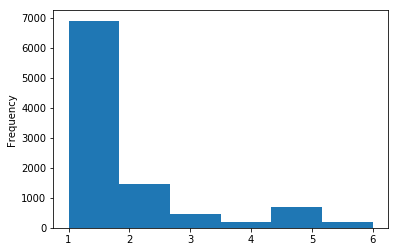

In [134]:
test_df.passenger_count.plot(kind='hist',bins=6)

In [135]:
test_df.passenger_count.value_counts()

1    6914
2    1474
5     696
3     447
4     206
6     177
Name: passenger_count, dtype: int64

In [136]:
train_df.passenger_count.value_counts().sort_index()

0        190842
1      37518086
2       8013253
3       2383015
4       1155599
5       3841813
6       1150252
7            13
8             7
9            21
129           2
208          22
Name: passenger_count, dtype: int64

In [137]:
# number rows with passenger = 0 or more than 6
len(train_df[(train_df.passenger_count == 0) | (train_df.passenger_count > 6)])

190907

In [138]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.passenger_count > 0) & (train_df.passenger_count < 7)]
print('New size: %d' % len(train_df))

Old size: 54252925
New size: 54062018


## Checkpoint 2

In [139]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [140]:
%%time
train_df.to_feather('tmp/taxi-train-v2-chkpt2')

Wall time: 25.9 s


In [141]:
%%time
test_df.to_feather('tmp/taxi-test-v2-chkpt2')

Wall time: 77.5 ms


In [142]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v2-chkpt2')

Wall time: 1.86 s


In [143]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v2-chkpt2')

Wall time: 0 ns


# Fare Amount

In [144]:
train_df.fare_amount.median(), train_df.fare_amount.mean()

(8.5, 11.332756)

In [150]:
(train_df.fare_amount.quantile(0.99), train_df.fare_amount.quantile(0.999),
 train_df.fare_amount.quantile(0.9999),train_df.fare_amount.quantile(0.99999))

(52.099998474121094, 78.75, 140.0, 240.0)

In [151]:
(len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.99))]),
len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.999))]),
 len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.9999))]),
len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.99999))]))

(540334, 53831, 5405, 539)

In [146]:
len(train_df[(train_df.fare_amount==0)]) # those who paid nothing

1118

In [147]:
len(train_df[(train_df.fare_amount<0)])  # those who had refund?

2205

In [152]:
fare_amount_threshold = 150

In [153]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.fare_amount>0) & (train_df.fare_amount<fare_amount_threshold)] # tweakable
print('New size: %d' % len(train_df))

Old size: 54062018
New size: 54054206


In [154]:
# check fare_amount for zero travel distance from training data
train_df[train_df.simple_distance == 0].describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,582641.000000,582641.000000,582641.000000,582641.000000,582641.000000,582641.000000,582641.0,582641.0,582641.0
mean,11.051130,-73.943596,40.760849,-73.943596,40.760849,1.668237,0.0,0.0,0.0
std,13.634315,0.136692,0.100490,0.136692,0.100490,1.299024,0.0,0.0,0.0
min,0.010000,-74.561195,40.273090,-74.561195,40.273090,1.000000,0.0,0.0,0.0
25%,4.900000,-73.990646,40.733696,-73.990646,40.733696,1.000000,0.0,0.0,0.0
50%,6.900000,-73.975693,40.752258,-73.975693,40.752258,1.000000,0.0,0.0,0.0
75%,10.500000,-73.948097,40.767818,-73.948097,40.767818,2.000000,0.0,0.0,0.0
max,149.750000,-72.767593,41.916325,-72.767593,41.916325,6.000000,0.0,0.0,0.0


In [155]:
test_df[test_df.simple_distance == 0].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.0,85.0,85.0
mean,-73.922089,40.781349,-73.922089,40.781349,1.741176,0.0,0.0,0.0
std,0.181695,0.134858,0.181695,0.134858,1.337668,0.0,0.0,0.0
min,-74.047394,40.622555,-74.047394,40.622555,1.000000,0.0,0.0,0.0
25%,-73.983925,40.742584,-73.983925,40.742584,1.000000,0.0,0.0,0.0
50%,-73.970085,40.754883,-73.970085,40.754883,1.000000,0.0,0.0,0.0
75%,-73.951820,40.772038,-73.951820,40.772038,2.000000,0.0,0.0,0.0
max,-73.137390,41.366138,-73.137390,41.366138,6.000000,0.0,0.0,0.0


- There are 85 cases  of zero travel distance in test set. 
- There are 582,641 cases of zero travel distance in training set.
- Zero distance can also mean travel and come back to the same spot. In any case it's ambiguous case
- Fare amount in training set range from 0.01 to 149.75 as we have set limits to min and max fare previously
- Ignore this for now

## Checkpoint 3

In [156]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [157]:
%%time
train_df.to_feather('tmp/taxi-train-v2-chkpt3')

Wall time: 31 s


In [158]:
%%time
test_df.to_feather('tmp/taxi-test-v2-chkpt3')

Wall time: 41.3 ms


In [159]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v2-chkpt3')

Wall time: 1.92 s


In [160]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v2-chkpt3')

Wall time: 0 ns


# Date Time

In [161]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54054206 entries, 0 to 54054205
Data columns (total 10 columns):
fare_amount           float32
pickup_datetime       datetime64[ns]
pickup_longitude      float32
pickup_latitude       float32
dropoff_longitude     float32
dropoff_latitude      float32
passenger_count       uint8
abs_diff_longitude    float32
abs_diff_latitude     float32
simple_distance       float32
dtypes: datetime64[ns](1), float32(8), uint8(1)
memory usage: 2.1 GB


In [162]:
%%time
add_datepart(train_df, 'pickup_datetime', time=True)

Wall time: 5min 32s


In [163]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54054206 entries, 0 to 54054205
Data columns (total 25 columns):
fare_amount                        float32
pickup_longitude                   float32
pickup_latitude                    float32
dropoff_longitude                  float32
dropoff_latitude                   float32
passenger_count                    uint8
abs_diff_longitude                 float32
abs_diff_latitude                  float32
simple_distance                    float32
pickup_datetimeYear                int64
pickup_datetimeMonth               int64
pickup_datetimeWeek                int64
pickup_datetimeDay                 int64
pickup_datetimeDayofweek           int64
pickup_datetimeDayofyear           int64
pickup_datetimeIs_month_end        bool
pickup_datetimeIs_month_start      bool
pickup_datetimeIs_quarter_end      bool
pickup_datetimeIs_quarter_start    bool
pickup_datetimeIs_year_end         bool
pickup_datetimeIs_year_start       bool
pickup_datetim

In [17]:
cols_to_drop = [
    'pickup_datetimeIs_month_start',
    'pickup_datetimeIs_month_end',    
    'pickup_datetimeIs_quarter_start',
    'pickup_datetimeIs_quarter_end',
    'pickup_datetimeIs_year_start',
    'pickup_datetimeIs_year_end',  
    'pickup_datetimeSecond',
    'pickup_datetimeElapsed'
]

In [165]:
train_df.drop(cols_to_drop, axis='columns', inplace=True)

In [166]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54054206 entries, 0 to 54054205
Data columns (total 17 columns):
fare_amount                 float32
pickup_longitude            float32
pickup_latitude             float32
dropoff_longitude           float32
dropoff_latitude            float32
passenger_count             uint8
abs_diff_longitude          float32
abs_diff_latitude           float32
simple_distance             float32
pickup_datetimeYear         int64
pickup_datetimeMonth        int64
pickup_datetimeWeek         int64
pickup_datetimeDay          int64
pickup_datetimeDayofweek    int64
pickup_datetimeDayofyear    int64
pickup_datetimeHour         int64
pickup_datetimeMinute       int64
dtypes: float32(8), int64(8), uint8(1)
memory usage: 4.9 GB


In [8]:
def convert_datetimetype(df):
    df.pickup_datetimeYear = (df.pickup_datetimeYear-2000).astype('uint8')   
    df.pickup_datetimeMonth = df.pickup_datetimeMonth.astype('uint8') 
    df.pickup_datetimeDay = df.pickup_datetimeDay.astype('uint8')   
    df.pickup_datetimeWeek = df.pickup_datetimeWeek.astype('uint8')    
    df.pickup_datetimeHour = df.pickup_datetimeHour.astype('uint8')   
    df.pickup_datetimeMinute = df.pickup_datetimeMinute.astype('uint8')    
    df.pickup_datetimeDayofweek = df.pickup_datetimeDayofweek.astype('uint8')                 
    df.pickup_datetimeDayofyear = df.pickup_datetimeDayofyear.astype('uint16')   

In [9]:
convert_datetimetype(train_df)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54054206 entries, 0 to 54054205
Data columns (total 17 columns):
fare_amount                 float32
pickup_longitude            float32
pickup_latitude             float32
dropoff_longitude           float32
dropoff_latitude            float32
passenger_count             uint8
abs_diff_longitude          float32
abs_diff_latitude           float32
simple_distance             float32
pickup_datetimeYear         uint8
pickup_datetimeMonth        uint8
pickup_datetimeWeek         uint8
pickup_datetimeDay          uint8
pickup_datetimeDayofweek    uint8
pickup_datetimeDayofyear    uint16
pickup_datetimeHour         uint8
pickup_datetimeMinute       uint8
dtypes: float32(8), uint16(1), uint8(8)
memory usage: 2.1 GB


## Repeat on test dataframe

In [20]:
add_datepart(test_df, 'pickup_datetime', time=True)

In [21]:
test_df.drop(cols_to_drop, axis='columns', inplace=True)

In [22]:
convert_datetimetype(test_df)

In [23]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 16 columns):
pickup_longitude            9914 non-null float32
pickup_latitude             9914 non-null float32
dropoff_longitude           9914 non-null float32
dropoff_latitude            9914 non-null float32
passenger_count             9914 non-null uint8
abs_diff_longitude          9914 non-null float32
abs_diff_latitude           9914 non-null float32
simple_distance             9914 non-null float32
pickup_datetimeYear         9914 non-null uint8
pickup_datetimeMonth        9914 non-null uint8
pickup_datetimeWeek         9914 non-null uint8
pickup_datetimeDay          9914 non-null uint8
pickup_datetimeDayofweek    9914 non-null uint8
pickup_datetimeDayofyear    9914 non-null uint16
pickup_datetimeHour         9914 non-null uint8
pickup_datetimeMinute       9914 non-null uint8
dtypes: float32(7), uint16(1), uint8(8)
memory usage: 368.0 KB


## Checkpoint 4

In [25]:
%%time
train_df.to_feather('tmp/taxi-train-v2-chkpt4')

Wall time: 1min 15s


In [26]:
%%time
test_df.to_feather('tmp/taxi-test-v2-chkpt4')

Wall time: 399 ms


# Load Clean

In [7]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v2-chkpt4')

Wall time: 3.95 s


In [8]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v2-chkpt4')

Wall time: 0 ns


# Find nearest neighbour

In [9]:
y = train_df.pop('fare_amount')

In [10]:
X_train_gps = train_df[['pickup_longitude',
                  'pickup_latitude', 
                  'dropoff_longitude',
                  'dropoff_latitude']].values

X_test_gps = test_df[['pickup_longitude',
                 'pickup_latitude', 
                 'dropoff_longitude',
                 'dropoff_latitude']].values

In [11]:
X_train_dt = train_df[['pickup_datetimeYear',  
               'pickup_datetimeWeek',  
               'pickup_datetimeDayofweek',
               'pickup_datetimeHour']].copy()

X_test_dt = test_df[['pickup_datetimeYear',    
               'pickup_datetimeWeek',   
               'pickup_datetimeDayofweek',
               'pickup_datetimeHour']].copy()

In [12]:
len(X_train_dt), len(X_test_dt)

(54054206, 9914)

Find similar date and time, then narrow down to nearest pickup and drop off point

TODO in version3 - Find similar/nearby pickup and dropoff points, then narrow down to similar date time. 

In [48]:
%%time 

list_neighbours = []
list_min_dist_idx = []
list_max_dist_idx = []
list_min_dist = []
list_max_dist = []
length = len(X_test_dt)

for i in range(length):
    
    if (i%100==0): print(f"{(i+1):04}/{length}")

    # same year, at most 1 week difference, same hour of the day and same day of the week
    X_dt_sub = X_train_dt[(X_train_dt.pickup_datetimeYear == X_test_dt.iloc[i].pickup_datetimeYear) &
                          abs(X_train_dt.pickup_datetimeWeek-X_test_dt.iloc[i].pickup_datetimeWeek<2) &
                          (X_train_dt.pickup_datetimeHour==X_test_dt.iloc[i].pickup_datetimeHour) &
                          (X_train_dt.pickup_datetimeDayofweek == X_test_dt.iloc[i].pickup_datetimeDayofweek)]
    
#     print(f'Test No.{i+1} has {len(X_dt_sub)} matches')

    if len(X_dt_sub) > 0:
        
        list_neighbours = list_neighbours + list(X_dt_sub.index.values)
        dist = np.sum(np.square(X_train_gps[X_dt_sub.index] - X_test_gps[i,:]), axis=1) 
        
#         print(len(X_dt_sub.index))
#         print(X_dt_sub.index.values)
        
        arg_min = np.argmin(dist)
        list_min_dist.append(dist[arg_min])
        idx_min = X_dt_sub.index[arg_min]
        list_min_dist_idx.append(idx_min)
            
#         print("test target: {}".format(test_df.iloc[i]))
#         print("train target: {}".format(train_df.iloc[idx_min]))
       
        arg_max = np.argmax(dist)
        list_max_dist.append(dist[arg_max])
        idx_max = X_dt_sub.index[arg_max]
        list_max_dist_idx.append(idx_max)
        
    else:
        print(f'Error at {i}!')
        raise ValueError

0001/9914
0101/9914
0201/9914
0301/9914
0401/9914
0501/9914
0601/9914
0701/9914
0801/9914
0901/9914
1001/9914
1101/9914
1201/9914
1301/9914
1401/9914
1501/9914
1601/9914
1701/9914
1801/9914
1901/9914
2001/9914
2101/9914
2201/9914
2301/9914
2401/9914
2501/9914
2601/9914
2701/9914
2801/9914
2901/9914
3001/9914
3101/9914
3201/9914
3301/9914
3401/9914
3501/9914
3601/9914
3701/9914
3801/9914
3901/9914
4001/9914
4101/9914
4201/9914
4301/9914
4401/9914
4501/9914
4601/9914
4701/9914
4801/9914
4901/9914
5001/9914
5101/9914
5201/9914
5301/9914
5401/9914
5501/9914
5601/9914
5701/9914
5801/9914
5901/9914
6001/9914
6101/9914
6201/9914
6301/9914
6401/9914
6501/9914
6601/9914
6701/9914
6801/9914
6901/9914
7001/9914
7101/9914
7201/9914
7301/9914
7401/9914
7501/9914
7601/9914
7701/9914
7801/9914
7901/9914
8001/9914
8101/9914
8201/9914
8301/9914
8401/9914
8501/9914
8601/9914
8701/9914
8801/9914
8901/9914
9001/9914
9101/9914
9201/9914
9301/9914
9401/9914
9501/9914
9601/9914
9701/9914
9801/9914
9901/9914


In [13]:
import csv

In [50]:
list_min_dist_idx = list(set(list_min_dist_idx))
list_max_dist_idx = list(set(list_max_dist_idx))
list_neighbours = list(set(list_neighbours))

In [51]:
len(list_min_dist_idx),len(list_max_dist_idx),len(list_neighbours)

(9674, 2109, 3456857)

In [52]:
list_neighbours_no_max = list(set(list_neighbours).difference(set(list_max_dist_idx)))
list_neighbours_no_maxmin = list(set(list_neighbours_no_max).difference(set(list_min_dist_idx)))

In [53]:
len(list_neighbours_no_max),len(list_neighbours_no_maxmin)

(3454748, 3445082)

In [54]:
def write_csv(filename,list_val):
    with open(filename, "w") as output:
        writer = csv.writer(output, lineterminator='\n')
        for val in list_val:
            writer.writerow([val])    

In [55]:
write_csv('tmp/v2_all.csv', list_neighbours)   
write_csv('tmp/v2_no_max.csv', list_neighbours_no_max)
write_csv('tmp/v2_no_maxmin.csv', list_neighbours_no_maxmin)
write_csv('tmp/v2_min.csv', list_min_dist_idx)
write_csv('tmp/v2_max.csv', list_max_dist_idx)      
write_csv('tmp/v2_min_dist.csv', list_min_dist)
write_csv('tmp/v2_max_dist.csv', list_max_dist)

In [31]:
list_neighbours_no_maxmin = list(pd.read_csv('tmp/v2_no_maxmin.csv', header=None)[0])
list_min_dist_idx = list(pd.read_csv('tmp/v2_min.csv',header=None)[0])
list_neighbours_no_max = list(pd.read_csv('tmp/v2_no_max.csv',header=None)[0])

In [32]:
len(list_neighbours_no_max),len(list_neighbours_no_maxmin),len(list_min_dist_idx),

(3454748, 3445082, 9674)

# Save dataframes to be used directly

In [33]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v2-chkpt4')

Wall time: 2.04 s


In [34]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v2-chkpt4')

Wall time: 15.6 ms


In [35]:
# for training with validation
pruned_df = train_df.iloc[list_neighbours_no_maxmin]
val_df = train_df.iloc[list_min_dist_idx]

# for full traning with maybe 0.01 improvement
full_df = train_df.iloc[list_neighbours_no_max]

pruned_df.reset_index(drop=True, inplace=True)
full_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [36]:
len(full_df), len(train_df), len(val_df), len(test_df)

(3454748, 54054206, 9674, 9914)

In [37]:
%%time
pruned_df.to_feather('tmp/taxi-v2-train')

Wall time: 141 ms


In [38]:
%%time
val_df.to_feather('tmp/taxi-v2-val')

Wall time: 11 ms


In [39]:
%%time
full_df.to_feather('tmp/taxi-v2-full')

Wall time: 218 ms


In [40]:
%%time
test_df.to_feather('tmp/taxi-test-v2')

Wall time: 20 ms
